# Import libraries and init

In [346]:
# import ROOT -- don't need this for now
import numpy as np
import pandas as pd
from collections import OrderedDict
import math

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 9})

import uproot # uproot needs to be last for some reason

In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [16]:
from functools import reduce
import operator

# Load ntuples from analyzer

Define parameters in separate block so can change them without loading files all over again

In [383]:
masses = [('60p0','20p0'),('6p0','2p0'),('52p5','5p0'),('5p25','0p5')]
printMasses = lambda mass: f'({float(mass[0].replace("p","."))-float(mass[1].replace("p","."))/2}, ' + \
                                f'{float(mass[0].replace("p","."))+float(mass[1].replace("p","."))/2}) GeV'
mchis = dict([(mass[0], printMasses(mass)) for mass in masses])
ctaus = [10]#, 10, 100, 1000]

numCuts = np.arange(0,6)
labels = [ f'cut{cut}' for cut in numCuts ]
cutDescriptions = ['cut1: MET/MHT trigger fired (120 GeV)', \
                   'cut2: j1 pT > 120 GeV, <= 2j w/ pT > 30 GeV', \
                   'cut3: mu1 pT > 5 GeV, 0.1 < |dxy| < 700 cm', \
                   'cut4: mu2 pT > 5 GeV, 0.1 < |dxy| < 700 cm', \
                   r'cut5: $|\Delta\Phi$(MET, mu pair)| < 0.4'
                  ]

branchPath = 'SREffi_dsa'
baseDir = '../Firefighter/washAOD/SROptimization/'
fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

Load signal files

In [246]:
numParams = len(masses)*len(ctaus)
countParam = 1

trees = OrderedDict({})
genInfo = OrderedDict({})
numEvents = OrderedDict({})
for (Mchi, dMchi) in masses:
    countCtaus = 1
    trees[Mchi] = OrderedDict({})
    numEvents[Mchi] = OrderedDict({})
    genInfo[Mchi] = OrderedDict({})
    for ctau in ctaus:
        genInfo[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN/gen']#.pandas.df(flatten=False)
        trees[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))[branchPath + f'/cutsTree']#.pandas.df(flatten=False)
        print(f'{countParam} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
        countParam += 1

1 of 4: ../Firefighter/washAOD/SROptimization/Mchi-60p0_dMchi-20p0_ctau-10.root
2 of 4: ../Firefighter/washAOD/SROptimization/Mchi-6p0_dMchi-2p0_ctau-10.root
3 of 4: ../Firefighter/washAOD/SROptimization/Mchi-52p5_dMchi-5p0_ctau-10.root
4 of 4: ../Firefighter/washAOD/SROptimization/Mchi-5p25_dMchi-0p5_ctau-10.root


Load background files

In [7]:
# dfs['QCD_bEnriched_HT500to700'] = uproot.open('root://cmsxrootd.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/backgrounds/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/Mchi-60p0_dMchi-20p0_ctau-1.root')['SREffi_dsa/cutsTree'].pandas.df()
# dfs['DYJetsToLL'] = uproot.open('/tmp/as2872/DYJetsToLL.root')['SREffi_dsa/cutsTree'].pandas.df()
# dfs['ZJetsToNuNu'] = uproot.open('/tmp/as2872/ZJetsToNuNu.root')['SREffi_dsa/cutsTree'].pandas.df()
tree['ZJetsToNuNu'] = uproot.open('root://cmsxrootd.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/backgrounds/ZJetsToNuNu.root')['SREffi_dsa/cutsTree']#.pandas.df(flatten=False)

Create pandas dataframes for different physics objects now that uproot won't flatten them anymore
(does make code faster)

In [336]:
leadingJet = OrderedDict({}); MET = OrderedDict({});
muons = OrderedDict({}); vertex = OrderedDict({});
cuts = OrderedDict({}); cutsCrit = OrderedDict({})

for mchi in mchis:
    leadingJet[mchi] = trees[mchi][10].pandas.df(['recoPFJetPt','recoPFJetEta','recoPFJetPhi']).loc[(slice(None),0),slice(None)].reset_index(level=1)
    MET[mchi] = trees[mchi][10].pandas.df(['recoPFMetPt', 'recoPFMetPhi'])#.reset_index(level=1)
    muons[mchi] = trees[mchi][10].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz']).reset_index(level=1)
    vertex[mchi] = trees[mchi][10].pandas.df(['recoDr','recoVxy','recoVz']).reset_index(level=1)
    cuts[mchi] = trees[mchi][10].pandas.df('cutsVec*')
    cutsCrit[mchi] = [ cuts[mchi][f'cutsVec[{cut}]'] == 1 for cut in numCuts ]

Separately calculate the phi average angle between the two muons -- for use in DeltaPhi(MET, muon pair) -- since it takes a while

In [375]:
# Helper function to calculate average angles
# This takes a few seconds to run, since we 
# are using the apply method
def calcAvgAngle(group):
    x = np.cos(group['recoPhi'].iloc[0]) + np.cos(group['recoPhi'].iloc[-1])
    y = np.sin(group['recoPhi'].iloc[0]) + np.sin(group['recoPhi'].iloc[-1])
    return math.atan2(y/2, x/2)

for mchi in mchis:
    avgMuonAngle[mchi] = muons[mchi].groupby('entry').apply(calcAvgAngle)

# Inclusive cuts

In [337]:
cutFlowDict = OrderedDict()
for mchi in mchis:
    cutFlowDict[mchi] = []
    for cut in numCuts:
        cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
        cutFlowDict[mchi].append(len(cuts[mchi][cutsToApply]))
        
cutFlowInclDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowInclDf

,60p0,6p0,52p5,5p25
0,73968,23622,85517,30655
1,21571,4681,27116,5806
2,13698,2844,19142,3984
3,10688,1941,8999,1403
4,5165,601,2053,262
5,2463,575,1433,235


In [53]:
bkg = 'ZJetsToNuNu'
cutFlowDict[bkg] = []
cutsCrit = [ dfs[bkg][f'cutsVec[{cut}]']==1 for cut in cuts ]
for cut in cuts:
    cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1])
    cutFlowDict[bkg].append(len(dfs[bkg][cutsToApply]))

In [55]:
print(cutFlowDict['QCD_bEnriched_HT500to700'])
print(cutFlowDict['DYJetsToLL'])
print(cutFlowDict['ZJetsToNuNu'])

[132636, 752, 103, 46, 9, 7]
[271207, 94, 18, 7, 1, 0]
[260268, 14466, 7436, 460, 29, 2]


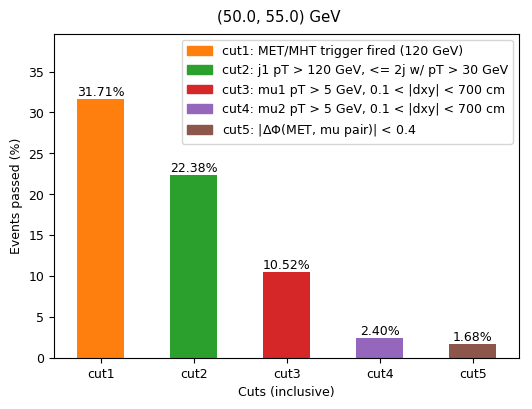

In [381]:
mchi = '52p5'
fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f'{mchis[mchi]}')
fig.subplots_adjust(top=0.92)

# Histogram cut-flow of passing events
axlabels = [ f'cut{cut}' for cut in numCuts ]
data = 100 * cutFlowInclDf[mchi][1:] / cutFlowInclDf[mchi][0]
data.plot(ax=axes, kind='bar', color=['C1','C2','C3','C4','C5'])
axes.set_xlabel('Cuts (inclusive)')
axes.set_ylabel('Events passed (%)')
axes.set_xticklabels(axlabels[1:], rotation=0)
axes.set_xticks(np.arange(0,5))
axes.set_ylim(0, 1.25*max(data))

# Make bar labels
rects = axes.patches
barlabels = ["%.2f%%" % data[i] for i in np.arange(1,len(rects)+1)]
for rect, label in zip(rects, barlabels):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')

# Make legend
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=f'C{c}', label=cutDescriptions[c-1]) for c in np.arange(1,6) ]
axes.legend(handles=patches)#, fontsize='small');

# Exclusive cuts

In [350]:
cutFlowDict = OrderedDict()
for mchi in mchis:
    cutFlowDict[mchi] = []
    for cut in numCuts:
        cutsToApply = cutsCrit[mchi][cut]
        cutFlowDict[mchi].append(len(cuts[mchi][cutsToApply]))
        
cutFlowExclDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowExclDf

,60p0,6p0,52p5,5p25
0,73968,23622,85517,30655
1,21571,4681,27116,5806
2,28861,8132,33789,10281
3,58544,13955,32446,6036
4,28538,3931,6231,733
5,14902,9360,11031,4680


# Plot everything together

To plot individual plots separately, copy relevant block of code and replace "axes[i,j]" with "plt", and take note that some of the functions change name, e.g. axes[i,j].set_xlabel() --> plt.xlabel() and axes[i,j].set_ylim() --> plt.ylim().

The other option is to copy the block and add "fig, ax = plt.subplots(1,1)" at the top, and then do the replacement axes[i,j] --> ax elsewhere.

## Helper functions

In [366]:
insets = False
log = True
histtype ='step'
iheight="65%"
iwidth="45%"

def plot_inset(data, axis, kwargs={}):
    if 'bins' not in kwargs: kwargs['bins'] = 10
    if 'histtype' not in kwargs: kwargs['histtype'] = build
    if insets:
        axins = inset_axes(axis, width=iwidth, height=iheight)
        for (cut,datum) in enumerate(data):
            ret = axins.hist(datum, **kwargs)
            if cut == 1:
                axins.set_ylim(0,1.1*max(ret[0]))
        return axins

def plot_full(data, axis, kwargs={}, labels = []):
    if 'bins' not in kwargs: kwargs['bins'] = 50
    if 'histtype' not in kwargs: kwargs['histtype'] = histtype
    if 'log' not in kwargs: kwargs['log'] = log
    for (cut,datum) in enumerate(data):
        ret = axis.hist(datum, label=(labels[cut] if len(labels) > 0 else ''), **kwargs)
        if cut == 0:
            axis.set_ylim(1, 1.5*max(ret[0]))
            
# Helper function to normalize angle differences to [-Pi, Pi]
# cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
def reducephi(row):
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

## Plot MET and jet variables

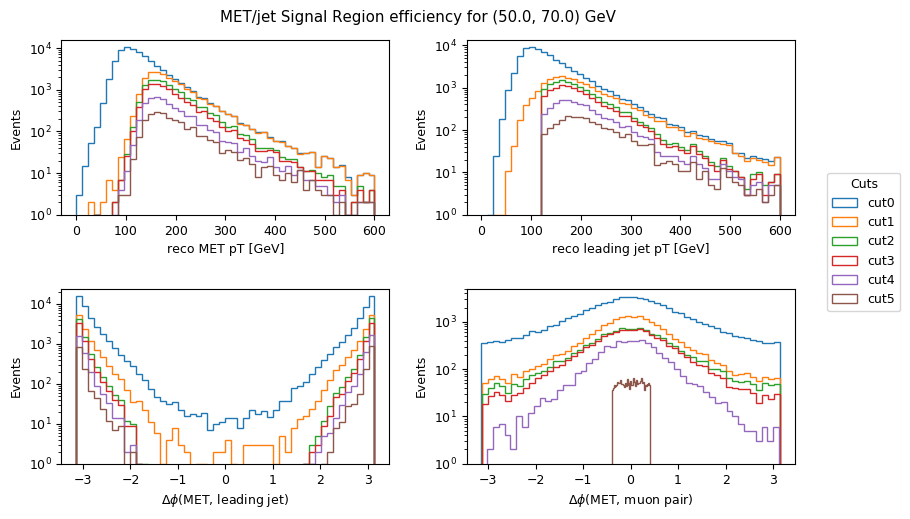

In [384]:
mchi = '60p0'

### Make subplot axes
fig, axes = plt.subplots(2,2, figsize=(8,5))
plt.tight_layout(h_pad=4.0, w_pad=3.0)
for row in axes:
    for col in row:
        col.set_ylabel('Events')
        
fig.suptitle(f'MET/jet Signal Region efficiency for {mchis[mchi]}')
fig.subplots_adjust(top=0.92)

    
### reco MET pT
axes[0,0].set_xlabel('reco MET pT [GeV]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(MET[mchi][cutsToApply]['recoPFMetPt'])
plot_full(data, axes[0,0], dict({'range':(0,600)}))


### reco leading jet pT
axes[0,1].set_xlabel('reco leading jet pT [GeV]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(leadingJet[mchi][cutsToApply]['recoPFJetPt'])
plot_full(data, axes[0,1], dict({'range':(0,600)}), labels=labels)


### reco deltaPhi(MET, jet)
axes[1,0].set_xlabel(r'$\Delta\phi$(MET, leading jet)')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    angle = MET[mchi][cutsToApply]['recoPFMetPhi'] - leadingJet[mchi][cutsToApply]['recoPFJetPhi']
    reducedAngle = angle.apply(reducephi)
    data.append(reducedAngle)
plot_full(data, axes[1,0])


### DeltaPhi b/w MET and muon pair
axes[1,1].set_xlabel(r'$\Delta\phi$(MET, muon pair)')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    angleDiff = (MET[mchi][cutsToApply]['recoPFMetPhi'].dropna() - avgMuonAngle[mchi]).dropna()
    reducedAngleDiff = angleDiff.apply(reducephi).dropna()
    data.append(reducedAngleDiff)
plot_full(data, axes[1,1])

    
### Make and place legend w.r.t. axis[0,1] (upper right)
axes[0,1].legend(loc=(1.1,-0.55), title='Cuts');

## Plot muon variables

/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


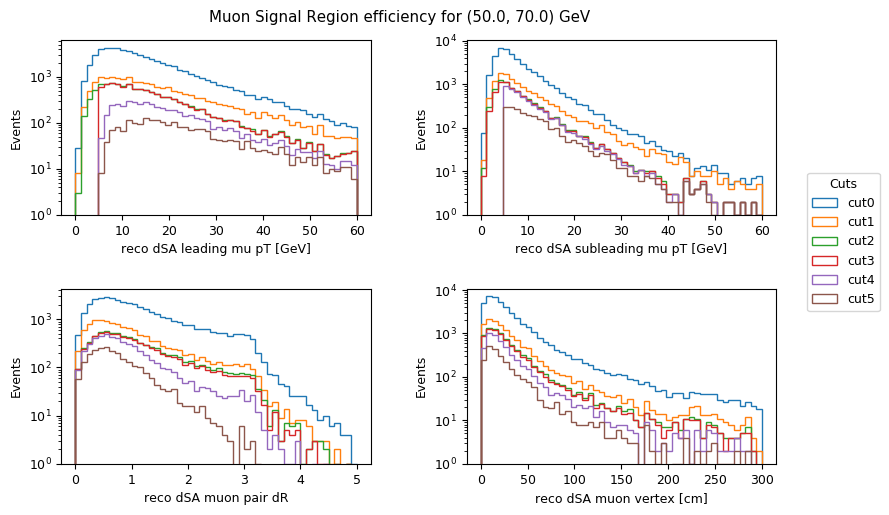

In [380]:
mchi = '60p0'

### Make subplot axes
fig, axes = plt.subplots(2,2, figsize=(8,5))
for row in axes:
    for col in row:
        col.set_ylabel('Events')
plt.tight_layout(h_pad=4.0, w_pad=3.0)

fig.suptitle(f'Muon Signal Region efficiency for {mchis[mchi]}')
fig.subplots_adjust(top=0.92)


### reco dSA leading muon pT
axes[0,0].set_xlabel('reco dSA leading mu pT [GeV]')
# data = [dfs[mchi][10][cut].query('subentry==0')['recoPt'].dropna() for cut in cuts]
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(muons[mchi][cutsToApply]['recoPt'].groupby('entry').nth(0))
plot_full(data, axes[0,0], dict({'range':(0,60)}))


### reco dSA subleading muon pT
axes[0,1].set_xlabel('reco dSA subleading mu pT [GeV]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(muons[mchi][cutsToApply]['recoPt'].groupby('entry').nth(1))
plot_full(data, axes[0,1], dict({'range':(0,60)}), labels=labels)


### muon deltaR
axes[1,0].set_xlabel('reco dSA muon pair dR')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(vertex[mchi][cutsToApply]['recoDr'])
plot_full(data, axes[1,0], dict({'range':(0,5)}))


### muon vertex
axes[1,1].set_xlabel('reco dSA muon vertex [cm]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(np.sqrt(vertex[mchi][cutsToApply]['recoVxy']**2 + vertex[mchi][cutsToApply]['recoVz']**2))
plot_full(data, axes[1,1], dict({'range':(0,300)}))


### Make and place legend w.r.t. axis[0,1] (upper right)
axes[0,1].legend(loc=(1.1,-0.55), title='Cuts');

In [ ]:
# Backup for previous way of calculating subleading muon pT and leading muon d0

# ### reco dSA subleading muon pT
# axes[0,1].set_xlabel('reco dSA subleading mu pT [GeV]')
# data = []
# for cut in cuts:
#     cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1]).reset_index()
#     cutsToApply.columns = ['entry', 'subentry', 'cutsResult']
#     accptdEntries = cutsToApply.reset_index().loc[cutsToApply.reset_index()['cutsResult'] == True]['entry']

#     data.append(dfs[mchi].reset_index().loc[ dfs[mchi].reset_index()['entry'].isin(accptdEntries) & \
#                                        dfs[mchi].reset_index()['subentry'].isin([1]) ]['recoPt'].dropna())
    
# # labels = [f'cut{cut}' for cut in np.arange(0,6)]
# # plot_full(data, axes[0,1], dict({'range':(0,60)}), labels=labels)

# ### muon d0 (leading)
# axes[1,1].set_xlabel('reco dSA leading mu d0 [cm]')
# data = []
# for cut in cuts:
#     cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1])
#     data.append(np.sqrt(dfs[mchi][10][cutsToApply].query('subentry==0')['recoDz'].dropna()**2 + \
#                 dfs[mchi][10][cutsToApply].query('subentry==0')['recoDxy'].dropna()**2))
# plot_full(data, axes[1,1], dict({'range':(0,300)}))

# Scratch tests and comparisons

Comparing results before and after fixing Dxy acceptance (i.e. Dxy is a signed distance and can be < 0)

In [200]:
testdfs = uproot.open("../Firefighter/washAOD/SROptimization/beforeFixingDxy/Mchi-60p0_dMchi-20p0_ctau-10.root")['SREffi_dsa' + f'/cutsTree'].pandas.df()

In [98]:
testdf2 = uproot.open("../Firefighter/washAOD/SROptimization/Mchi-60p0_dMchi-20p0_ctau-10.root")['SREffi_dsa' + f'/cutsTree'].pandas.df()

First block is for number of leading muons, second block for subleading, and third block for vertex

In [99]:
# Total number of events
print(len(testdf2.query('subentry==0')['recoPt']))
# Total number of leading muons reconstructed
print(len(testdf2.query('subentry==0')['recoPt'].dropna()))
# Total number of leading muons reconstructed with at least 5 GeV pT
print(len(testdf2.query('subentry==0')[['recoPt']].query('recoPt>5')))
print()
# Same for subleading muons
print(len(testdf2.query('subentry==1')[['recoPt']]))
print(len(testdf2.query('subentry==1')[['recoPt']].dropna()))
print(len(testdf2.query('subentry==1')[['recoPt']].query('recoPt>5')))
print()
# Number of events total, and number of events with vertex info
# Note this number is the same as number of subleading muons reconstructed
# So we have a vertex every time two muons are reconstructed
print(len(testdf2.query('subentry==0')[['recoVxy']]))
print(len(testdf2.query('subentry==0')[['recoVxy']].dropna()))

73968
65532
59393

73627
44229
29825

73968
44229


In [101]:
# Comparison for subleading muons, here we are 'emulating' the cut that I'm suspicious about.
# Goal is to find out which cut of the subleading muons is the most restrictive.

# All events
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']]))
# Events with subleading muon reconstructed
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']].dropna()))
# Now require at least 5 GeV pT
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']].loc[ testdf2.recoPt > 5 ]))
# Further require dxy to be between 0.1 and 700 cm as in the Analyzer cut
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']].loc[(testdf2.recoPt > 5) & (0.1 < testdf2.recoDxy.abs()) & (700 > testdf2.recoDxy.abs())]))
# The difference between the exclusive cut4 number reported in the table above and the final number here in
# this block is due solely to the "vertex valid" requirement, 29532 - 28538 = 994. Only 994 events are
# excluded due to invalid vertex reconstruction (but this if for (50, 70) GeV masses)

73627
44229
29825
29532


Old inclusive cutflow to highlight the increased signal efficiency after fixing the dxy treatment (compare with inclusive cutflow table above).

611 vs 2463 for (50, 70) GeV (x4 difference)

In [201]:
mchi='60p0'
cutFlowDict = OrderedDict()
# for mchi in ['5p25','6p0','52p5','60']:
cutFlowDict[mchi] = []
cutsCrit = [ testdfs[f'cutsVec[{cut}]']==1 for cut in cuts ]
for cut in cuts:
    cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1])
    cutFlowDict[mchi].append(len(testdfs[cutsToApply]))
        
cutFlowDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowDf

,60p0
0,73968
1,21571
2,13698
3,5186
4,1262
5,611


Old exclusive cutflow to highlight the increased signal efficiency after fixing the dxy treatment (compare with exclusive cutflow table above)

Basiclly a factor of x2 in the exclusive cuts 3 and 4 (muon-related cuts). The factor is different in the inclusive cutflow (i.e. better) because a lot of the recovered events will pass other cuts as well.

In [104]:
mchi = '60p0'
cutFlowDict = OrderedDict()
# for mchi in ['5p25','6p0','52p5','60']:
cutFlowDict[mchi] = []
cutsCrit = [ testdfs[f'cutsVec[{cut}]']==1 for cut in np.arange(0,6) ]
for cut in np.arange(0,6):
    cutsToApply = cutsCrit[cut]
    cutFlowDict[mchi].append(len(testdfs[cutsToApply]))
        
cutFlowDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowDf

,60p0
0,73968
1,21571
2,28861
3,29044
4,14268
5,14902
